# Predict whether an adult is at risk of Diabetes
using 2015 BRFSS (Behavioral Risk Factor Surveillance System) health indicators.
Dataset: diabetes_012_health_indicators_BRFSS2015 (Kaggle)

Binary Classification:
- Positive (1): Diabetes or Prediabetes (original labels 2 or 1)
- Negative (0): No diabetes (original label 0)

#### Use case:
Early population screening to reduce missed diabetics so they get confirmatory testing and lifestyle/medical interventions.
#### Cost of errors:
- False Negative (miss a diabetic): Potential complications, higher costs later → very costly.
- False Positive (flag a healthy person): Extra test/visit → lower cost, often acceptable in screening.

Optimize the model to catch as many true diabetics as possible while keeping false alarms reasonable.
#### Evaluation:
- Primary metric: Recall (Sensitivity) on the positive class (diabetes+prediabetes).
- Precision, F1 (binary), Balanced Accuracy, AUROC, and AUPRC (more informative under imbalance).
- Validation: Stratified CV to preserve class ratios.

With severe class imbalance, accuracy can be misleading; we’ll emphasize recall, F1, balanced accuracy, and PR-based analysis.

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [4]:
df.shape

(253680, 22)

In [5]:
for col in df:
    print(f'{col}:', df[col].unique())

Diabetes_012: [0. 2. 1.]
HighBP: [1. 0.]
HighChol: [1. 0.]
CholCheck: [1. 0.]
BMI: [40. 25. 28. 27. 24. 30. 34. 26. 33. 21. 23. 22. 38. 32. 37. 31. 29. 20.
 35. 45. 39. 19. 47. 18. 36. 43. 55. 49. 42. 17. 16. 41. 44. 50. 59. 48.
 52. 46. 54. 57. 53. 14. 15. 51. 58. 63. 61. 56. 74. 62. 64. 66. 73. 85.
 60. 67. 65. 70. 82. 79. 92. 68. 72. 88. 96. 13. 81. 71. 75. 12. 77. 69.
 76. 87. 89. 84. 95. 98. 91. 86. 83. 80. 90. 78.]
Smoker: [1. 0.]
Stroke: [0. 1.]
HeartDiseaseorAttack: [0. 1.]
PhysActivity: [0. 1.]
Fruits: [0. 1.]
Veggies: [1. 0.]
HvyAlcoholConsump: [0. 1.]
AnyHealthcare: [1. 0.]
NoDocbcCost: [0. 1.]
GenHlth: [5. 3. 2. 4. 1.]
MentHlth: [18.  0. 30.  3.  5. 15. 10.  6. 20.  2. 25.  1.  4.  7.  8. 21. 14. 26.
 29. 16. 28. 11. 12. 24. 17. 13. 27. 19. 22.  9. 23.]
PhysHlth: [15.  0. 30.  2. 14. 28.  7. 20.  3. 10.  1.  5. 17.  4. 19.  6. 12. 25.
 27. 21. 22.  8. 29. 24.  9. 16. 18. 23. 13. 26. 11.]
DiffWalk: [1. 0.]
Sex: [0. 1.]
Age: [ 9.  7. 11. 10.  8. 13.  4.  6.  2. 12.  5.  1.  3

### Column Guide (Features & Encodings)
#### Target:
- Diabetes_012 (int: 0/1/2)
    - 0 = No diabetes
    - 1 = Prediabetes
    - 2 = Diabetes
#### Independent variables
- HighBP (0/1): Ever told you have high blood pressure.
- HighChol (0/1): Ever told you have high cholesterol.
- CholCheck (0/1): Cholesterol checked within past 5 years.
- BMI (integer): Body Mass Index.
- Smoker (0/1): Smoked at least 100 cigarettes in lifetime.
- Stroke (0/1): Ever told you had a stroke.
- HeartDiseaseorAttack (0/1): CHD or MI diagnosis.
- PhysActivity (0/1): Physical activity in past 30 days (beyond job).
- Fruits (0/1): Consumes fruit ≥1 time/day.
- Veggies (0/1): Consumes vegetables ≥1 time/day.
- HvyAlcoholConsump (0/1): Heavy drinker (men >14/week; women >7/week).
- AnyHealthcare (0/1): Have any kind of health care coverage.
- NoDocbcCost (0/1): Couldn’t see a doctor due to cost (past 12 months).
- GenHlth (1–5): Self-rated general health (1=Excellent … 5=Poor).
- MentHlth (0–30): Days mental health not good (past 30 days).
- PhysHlth (0–30): Days physical health not good (past 30 days).
- DiffWalk (0/1): Serious difficulty walking or climbing stairs.
- Sex (0/1): Sex (dataset-encoded; often 0=Female, 1=Male; will confirm).
- Age (1–13): Age categories
    - 1: 18–24, 2: 25–29, 3: 30–34, 4: 35–39, 5: 40–44, 6: 45–49,
7: 50–54, 8: 55–59, 9: 60–64, 10: 65–69, 11: 70–74, 12: 75–79, 13: 80+.
- Education (1–6):
    - 1=None/KG only, 2=Grades 1–8, 3=Grades 9–11, 4=Grade 12/GED, 5=College 1–3 yrs, 6=College 4+ yrs.
- Income (1–8):
    - 1=<$10k, 2=$10–15k, 3=$15–20k, 4=$20–25k, 5=$25–35k, 6=$35–50k, 7=$50–75k, 8=≥$75k.

### Binary Target

In [6]:
target_map = {0:0, 1:1, 2:1}
df['Diabetes_012'] = df['Diabetes_012'].map(target_map)
y = df['Diabetes_012']
y.unique()

array([0, 1])

### Target Variable Distribution

In [7]:
y.value_counts(normalize=True)*100

Diabetes_012
0    84.24117
1    15.75883
Name: proportion, dtype: float64

A severe imbalance is there and it requires weighted loss function or other imbalance strategies in modeling.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  int64  
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [9]:
df.isnull().sum().sum()

np.int64(0)

## EDA

### Feature Distributions

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
continuous_features = ['BMI','MentHlth', 'PhysHlth']

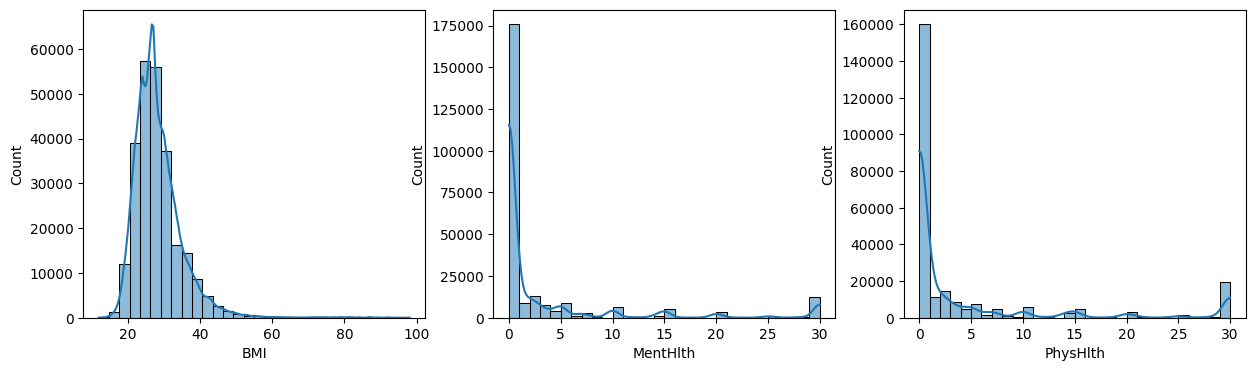

In [12]:
plt.figure(figsize=(15,4))
for i, feature in enumerate(continuous_features):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[feature], bins=30, kde=True)

<Axes: xlabel='Age', ylabel='count'>

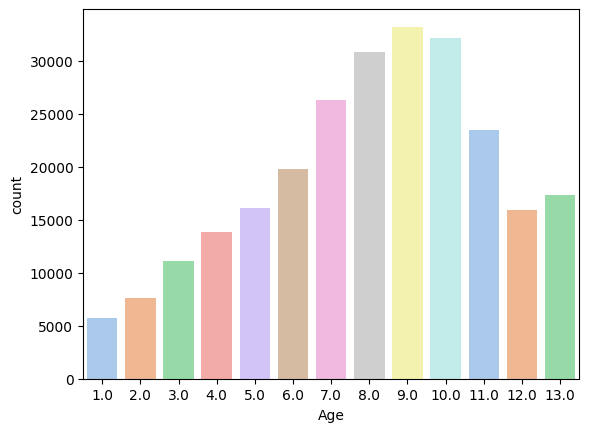

In [13]:
sns.countplot(x=df['Age'], palette='pastel')

<Axes: xlabel='GenHlth', ylabel='count'>

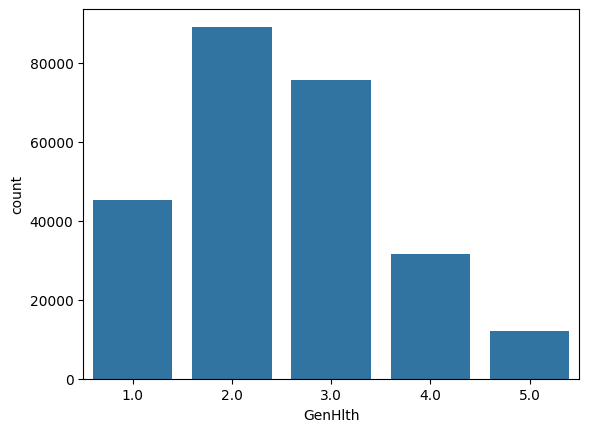

In [14]:
sns.countplot(x=df['GenHlth'])

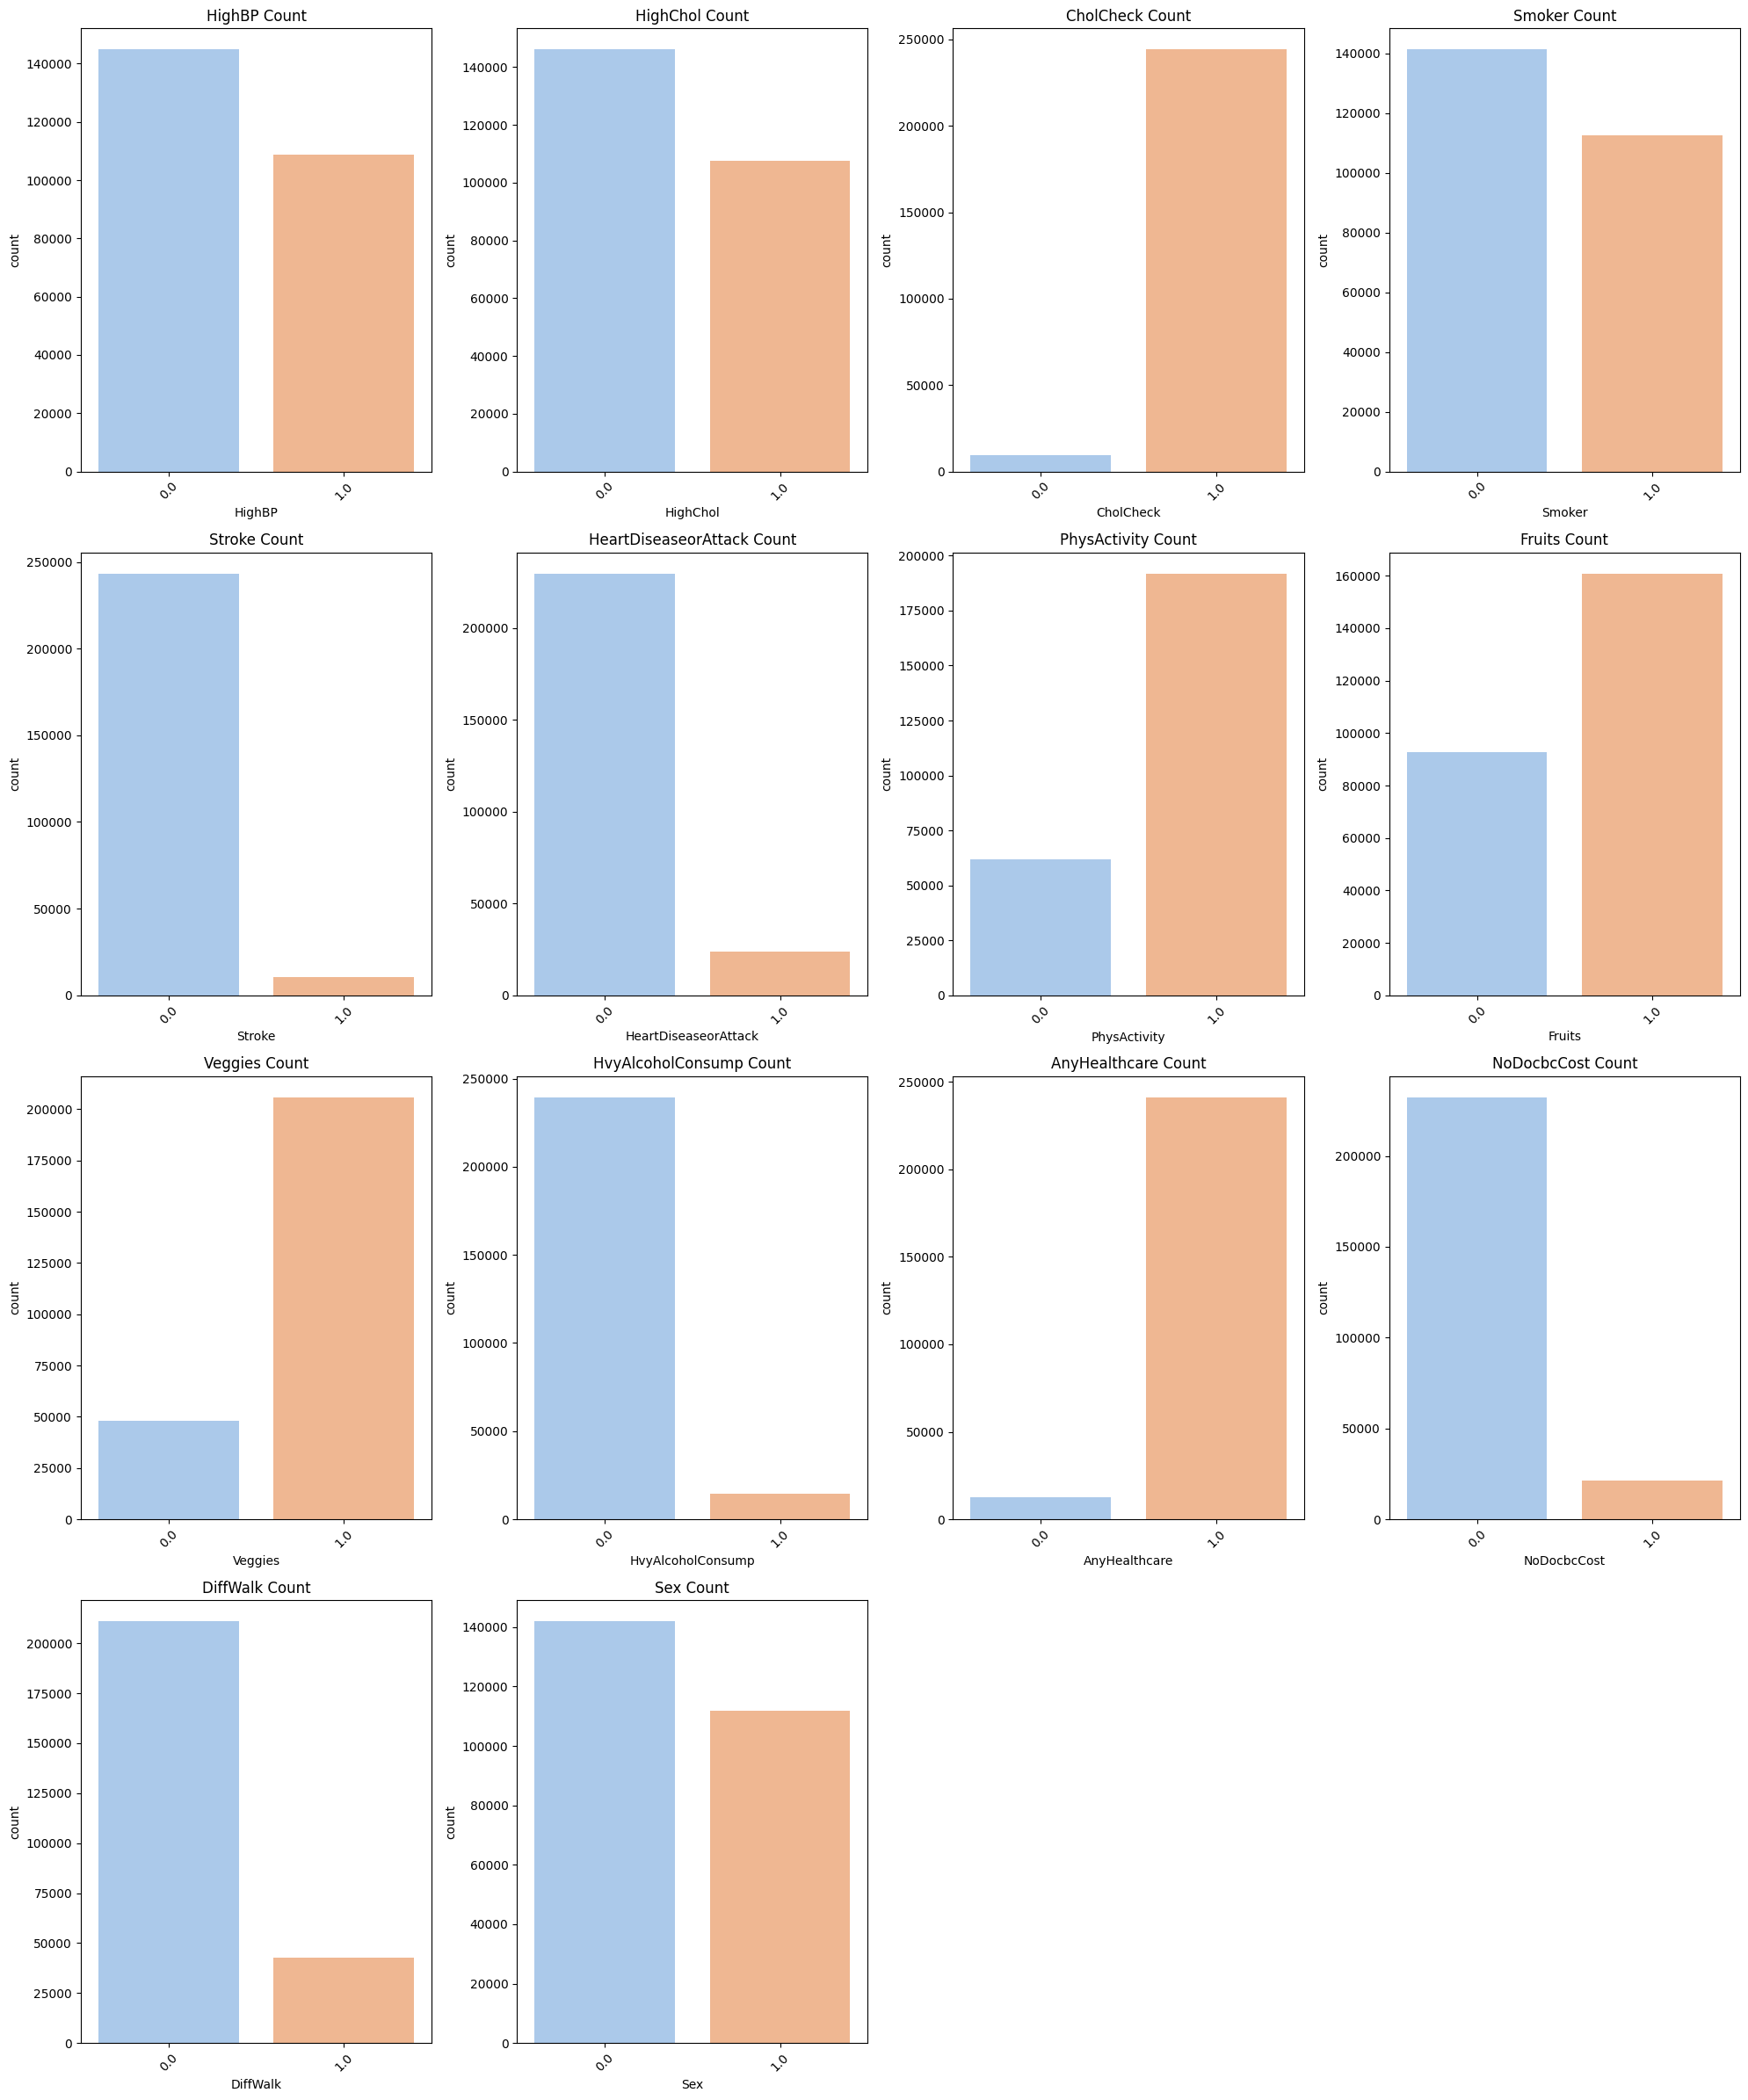

In [15]:
categorical_features = [ 'HighBP', 'HighChol', 'CholCheck', 
                        'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
                        'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 
                        'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

plt.figure(figsize=(20, 24))
for i, feature in enumerate(categorical_features):
    plt.subplot(4, 4, i+1)
    sns.countplot(x=df[feature], palette='pastel')
    plt.title(f'{feature} Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Hypertension (HighBP) & Diabetes

Higher prevalence of hypertension among diabetics.

Insight: Confirms known medical correlation.

- High Cholesterol & Diabetes

Diabetic respondents are more likely to have high cholesterol.

Portfolio note: Highlights multivariate risk factors beyond BMI/age.

- Physical Activity & Diabetes

Less physically active respondents show higher diabetes prevalence.

Implication: Behavioral interventions could be emphasized in risk mitigation.

- Smoking Status & Diabetes

Smoking prevalence slightly higher among positives, but less strongly correlated than BMI or HighBP.

### Correlation & Relationships

<Axes: >

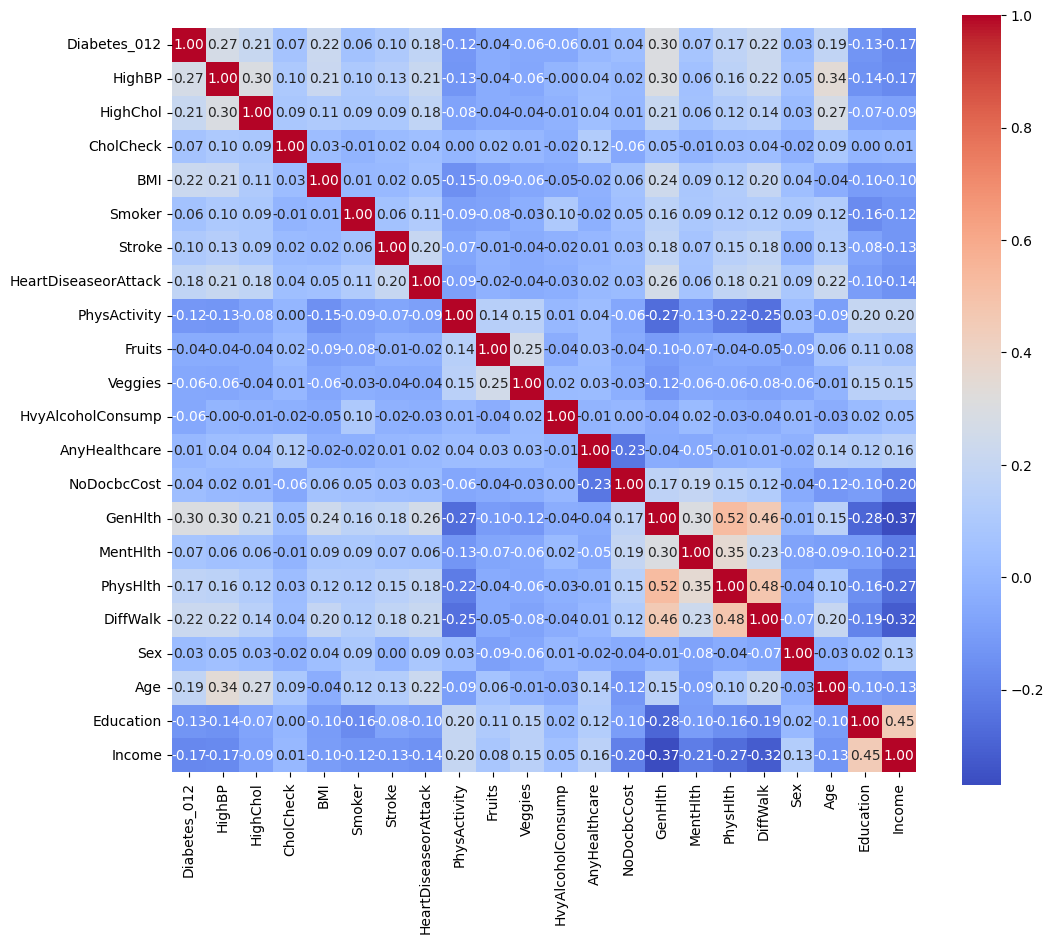

In [16]:
corr_mmatrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_mmatrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)

BMI, Age, HighBP, HighChol show positive correlation with diabetes binary target.

MentHlth and PhysHlth weakly correlated individually, may interact with other features.

In [17]:
df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

#### BMI vs Diabetes Status

Text(0, 0.5, 'BMI')

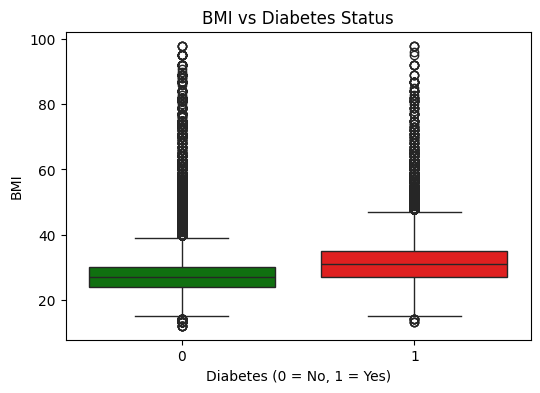

In [18]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Diabetes_012", y="BMI", data=df, palette=["green","red"])
plt.title("BMI vs Diabetes Status")
plt.xlabel("Diabetes (0 = No, 1 = Yes)")
plt.ylabel("BMI")

Diabetic/prediabetic group shifted toward higher BMI.

Outliers exist in both classes but are sparse.

Text(0.5, 1.0, 'BMI Distribution by Diabetes Status')

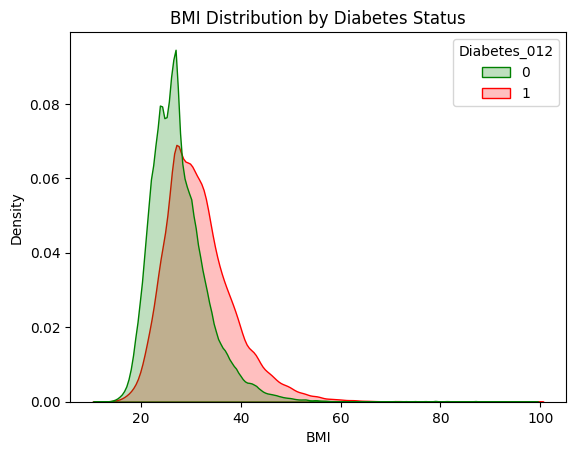

In [19]:
sns.kdeplot(data=df, x="BMI", hue="Diabetes_012", fill=True, common_norm=False, palette=["green","red"])
plt.title("BMI Distribution by Diabetes Status")

Most respondents have BMI between 20–40.

Positive cases show a higher mean BMI compared to negatives.

Extreme BMI values exist but are rare; may influence scaling-sensitive models.

#### Age vs Diabetes Status

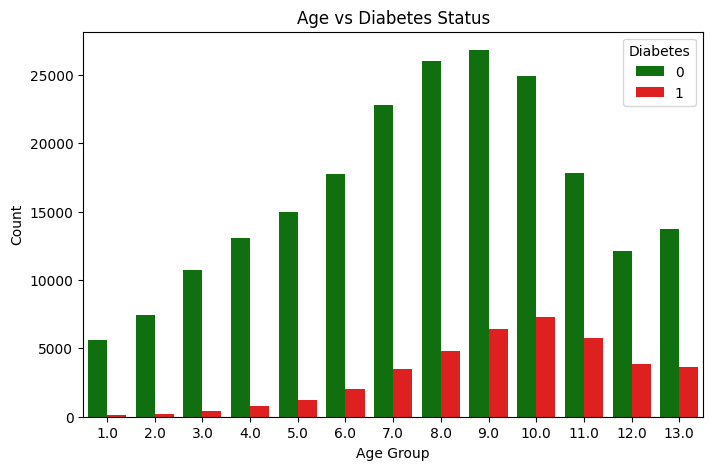

In [20]:
plt.figure(figsize=(8,5))
sns.countplot(x="Age", hue="Diabetes_012", data=df, palette=["green","red"])
plt.title("Age vs Diabetes Status")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.legend(title="Diabetes")

Majority of respondents are middle-aged (25–60).

Positive cases (diabetes/prediabetes) increase with age.

Insight: Age is a strong risk factor; older adults have higher diabetes prevalence.

#### HighBP & HighChol Prevalence

Prevalence (%)
                 HighBP   HighChol
Diabetes_012                      
0             37.113190  37.917109
1             73.834955  66.440703


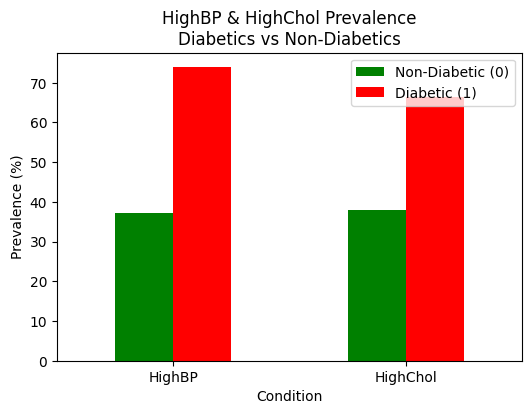

In [21]:
prevalence = df.groupby("Diabetes_012")[["HighBP", "HighChol"]].mean() * 100

print("Prevalence (%)")
print(prevalence)

prevalence.T.plot(kind="bar", figsize=(6,4), rot=0, color=["green","red"])
plt.title("HighBP & HighChol Prevalence\nDiabetics vs Non-Diabetics")
plt.ylabel("Prevalence (%)")
plt.xlabel("Condition")
plt.legend(["Non-Diabetic (0)", "Diabetic (1)"])


Expect BMI, Age, HighBP, HighChol to show strongest association with diabetes.

### Outlier & Data Quality Checks

#### flagging outliers like BMI < 10 or BMI > 70

In [22]:
df["BMI_flagged"] = ((df["BMI"] < 10) | (df["BMI"] > 70)).astype(int)

print("Extreme BMI values flagged:", df["BMI_flagged"].sum())

print(df[df["BMI_flagged"] == 1][["BMI", "Diabetes_012"]].head())

Extreme BMI values flagged: 584
        BMI  Diabetes_012
5611   74.0             0
10325  73.0             0
10705  73.0             0
11614  85.0             1
16580  73.0             0


Few respondents <10 or >70 → minor influence, may scale or cap for some models.

In [23]:
for col in ["MentHlth", "PhysHlth"]:
    print(f"\n{col} range:")
    print("Min:", df[col].min(), " Max:", df[col].max())
    invalid = df[(df[col] < 0) | (df[col] > 30)]
    print("Invalid count:", len(invalid))


MentHlth range:
Min: 0.0  Max: 30.0
Invalid count: 0

PhysHlth range:
Min: 0.0  Max: 30.0
Invalid count: 0


Mostly clean, survey-coded, categorical encodings confirmed.

### Key Insights after EDA
- Imbalance: Binary target is ~16% positive; requires class-weighted models.
- Strong predictive features: BMI, Age, HighBP, HighChol, Physical Activity.
- Weak or moderate predictors: Smoking, Mental Health, Fruit/Vegetable intake.
- Data quality: Mostly clean; few extreme values, mostly interpretable.

## Preprocessing

In [24]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Diabetes_012, dtype: int64

- Target is encoded and set.
- There is no missing values to Handle
- 

#### Scaling

##### Binary Features (0/1):
- HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, DiffWalk, Sex
- These are already on a consistent scale (0 or 1), so scaling is often unnecessary unless the algorithm is sensitive to small differences or you’re combining them with features on different scales.
##### Ordinal Features with Limited Range:
- GenHlth (1–5): Self-rated general health.
- Education (1–6): Education level.
- Income (1–8): Income categories.
- Age (1–13): Age categories.
- These features are ordinal (ordered categories) but have different ranges (5, 6, 8, and 13, respectively). Their varying magnitudes could disproportionately influence algorithms sensitive to scale

##### Numerical Feature with Wider Range:
- BMI (integer): Body Mass Index, typically ranging from ~15 to ~50 or higher (depending on the dataset).
- MentHlth (0–30): Days mental health not good.
- PhysHlth (0–30): Days physical health not good.
- These features have much larger ranges compared to the binary or ordinal features, making them prime candidates for scaling when using scale-sensitive algorithms.

In [25]:
numerical_features = ['BMI', 'MentHlth', 'PhysHlth']
ordinal_features = ['GenHlth', 'Education', 'Income', 'Age']
binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 
                  'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 
                  'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

In [26]:
df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'BMI_flagged'],
      dtype='object')

In [27]:
X = df[['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']]

## Model Training Pipeline

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

In [29]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('ord', StandardScaler(), ordinal_features),
    ('bin', StandardScaler(), binary_features)
]
)

In [30]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

## Train Test Split

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(202944, 21) (50736, 21) (202944,) (50736,)


### Handle Class Imbalance

In [32]:
y_train.value_counts(normalize=True)*100

Diabetes_012
0    84.240973
1    15.759027
Name: proportion, dtype: float64

In [33]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

pd.Series(y_train_resampled).value_counts(normalize=True)

Diabetes_012
1    0.5
0    0.5
Name: proportion, dtype: float64

In [34]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['BMI', 'MentHlth',
                                                   'PhysHlth']),
                                                 ('ord', StandardScaler(),
                                                  ['GenHlth', 'Education',
                                                   'Income', 'Age']),
                                                 ('bin', StandardScaler(),
                                                  ['HighBP', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'Stroke',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'AnyHealthcare',
                                                   'NoDocbcCost', 'DiffWalk',
                                                   'Sex'])])),
                ('classifier', LogisticRegression(class_weight='balanced'))])

              precision    recall  f1-score   support

           0       0.94      0.72      0.82     42741
           1       0.34      0.76      0.47      7995

    accuracy                           0.73     50736
   macro avg       0.64      0.74      0.64     50736
weighted avg       0.85      0.73      0.76     50736



Text(50.72222222222221, 0.5, 'True')

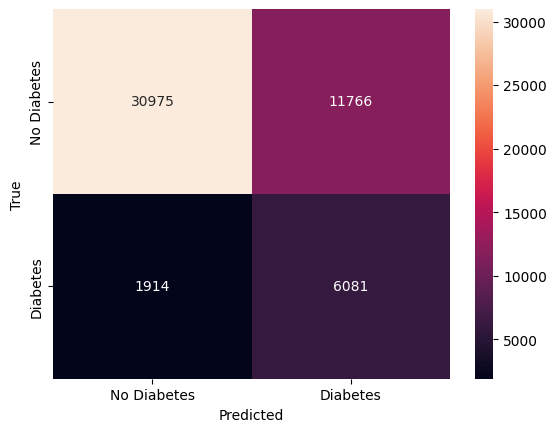

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = pipeline.predict(X_test)


print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
           xticklabels=['No Diabetes','Diabetes'],
           yticklabels=['No Diabetes','Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('True')

In [36]:
TN, FP, FN, TP = cm.ravel()

print(f"True Negatives (TN): {TN} (Predicted No Diabetes, True No Diabetes)")
print(f"False Positives (FP): {FP} (Predicted Diabetes, True No Diabetes)")
print(f"False Negatives (FN): {FN} (Predicted No Diabetes, True Diabetes)")
print(f"True Positives (TP): {TP} (Predicted Diabetes, True Diabetes)")

True Negatives (TN): 30975 (Predicted No Diabetes, True No Diabetes)
False Positives (FP): 11766 (Predicted Diabetes, True No Diabetes)
False Negatives (FN): 1914 (Predicted No Diabetes, True Diabetes)
True Positives (TP): 6081 (Predicted Diabetes, True Diabetes)


In a health-related context like diabetes classification, False Negatives (FN) are particularly concerning because they represent cases where individuals with diabetes (True Diabetes) are incorrectly predicted as not having diabetes (Predicted No Diabetes). Missing these cases can delay diagnosis and treatment, so reducing FN is a priority.

### Trying Balanced Data using SMOTE

pipeline.fit(X_train_resampled,y_train_resampled)

from sklearn.metrics import classification_report, confusion_matrix

y_pred = pipeline.predict(X_test)


print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
           xticklabels=['No Diabetes','Diabetes'],
           yticklabels=['No Diabetes','Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('True')

### KNN, SVM and DT Pipelines

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

knn_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

svm_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier', SVC(class_weight='balanced', probability=True, random_state=42))
])

dt_pipeline = Pipeline(steps=[
    ('preprocessor','passthrough'),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

In [51]:
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['BMI', 'MentHlth',
                                                   'PhysHlth']),
                                                 ('ord', StandardScaler(),
                                                  ['GenHlth', 'Education',
                                                   'Income', 'Age']),
                                                 ('bin', StandardScaler(),
                                                  ['HighBP', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'Stroke',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'AnyHealthcare',
                                                   'NoDocbcCost', 'DiffWalk',
                                                   'Sex'])])),
                ('classifier', KNeighborsClassifier())])

In [52]:
y_pred = knn_pipeline.predict(X_test)

In [53]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(50736,))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     42741
           1       0.43      0.24      0.31      7995

    accuracy                           0.83     50736
   macro avg       0.65      0.59      0.61     50736
weighted avg       0.80      0.83      0.81     50736



Text(50.72222222222221, 0.5, 'True')

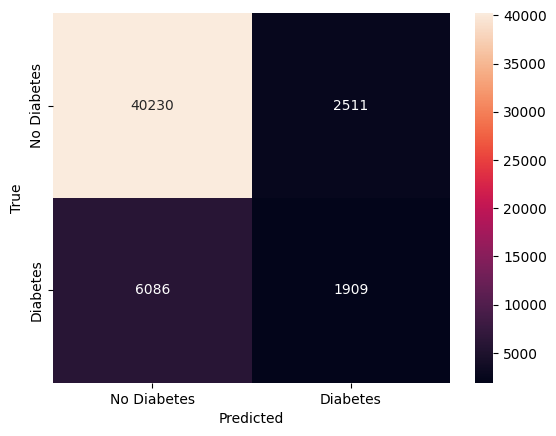

In [54]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
           xticklabels=['No Diabetes','Diabetes'],
           yticklabels=['No Diabetes','Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('True')

svm_pipeline.fit(X_train_resampled, y_train_resampled)

y_pred = svm_pipeline.predict(X_test)

In [43]:
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', 'passthrough'),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [44]:
y_pred = dt_pipeline.predict(X_test)

In [45]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(50736,))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87     42741
           1       0.31      0.32      0.31      7995

    accuracy                           0.78     50736
   macro avg       0.59      0.59      0.59     50736
weighted avg       0.78      0.78      0.78     50736



Text(50.72222222222221, 0.5, 'True')

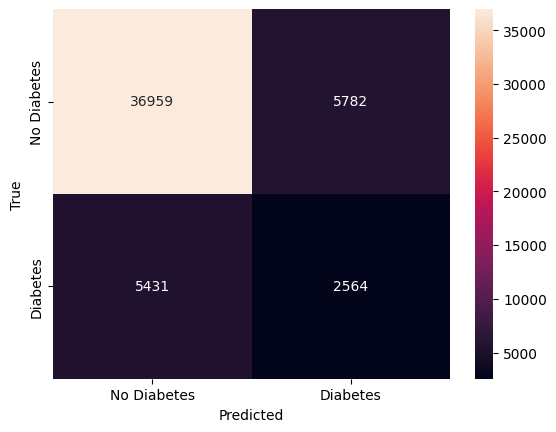

In [46]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
           xticklabels=['No Diabetes','Diabetes'],
           yticklabels=['No Diabetes','Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('True')